In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch_optimizer as optim

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exe_file = "/mnt/ssd1/nyh/AI_Competition"

/home/eslab/anaconda3/envs/nyh/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# train_img_shape = (1024, 1024)
train_img_shape = (256, 256)
train_resize_img_shape = (224, 224)
valid_img_shape = (224, 224)
test_img_shape = (224, 224)
batch_size = 64
threshold = 0.6
random_seed = 20230705
loss_func = [["DICE",0.8], ["FOCAL",0.2]] # first = DICE, second = FOCAL
model = smp.UnetPlusPlus
# model = smp.Unet
# model = smp.DeepLabV3
# model_name = ["timm-efficientnet-b4","noisy-student"]
# model_name = ["dpn92","imagenet+5k"]
model_name = ["se_resnext101_32x4d","imagenet"]
optimizer_name = "RAdam"

In [4]:
def random_seed_func(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

In [5]:
cpu_core_num = os.cpu_count()
gpu_num = torch.cuda.device_count()

print(f"{cpu_core_num} cpu cores")
print("Let's use", torch.cuda.device_count(), "GPUs!")

36 cpu cores
Let's use 4 GPUs!


## Utils
- https://dacon.io/competitions/official/236092/talkboard/408732?page=1&dtype=recent


In [6]:
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7):
    '''
    Calculate Dice Score between two binary masks.
    '''
    scores = []
    for i in range(prediction.shape[0]):
        intersection = np.sum(prediction[i] * ground_truth[i])
        score = (2.0 * intersection + smooth) / (np.sum(prediction[i]) + np.sum(ground_truth[i]) + smooth)

        scores.append(score)

    scores = sum(scores)/prediction.shape[0]
    return scores


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)):
    print(ground_truth_df.shape, prediction_df.shape)

    # Find the indices where the prediction ids exist in the ground truth ids
    prediction_ids = prediction_df.tolist()
    ground_truth_ids = ground_truth_df.tolist()
    matching_indices = [i for i in range(len(prediction_ids)) if prediction_ids[i] in ground_truth_ids]

    # Filter the prediction and ground truth dataframes based on the matching indices
    prediction_df = prediction_df[matching_indices]
    ground_truth_df = ground_truth_df[matching_indices]

    # # Extract the mask_rle columns
    print(ground_truth_df.shape, prediction_df.shape)
    pred_mask_rle = prediction_df
    gt_mask_rle = ground_truth_df
    # pred_mask_rle = prediction_df[:, 0, :, :].squeeze(0)
    # gt_mask_rle = ground_truth_df.squeeze(0)

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None

    dice_scores = []
    for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle):
        dice_score = calculate_dice(pred_rle, gt_rle)
        # print(dice_score)
        if dice_score is not None:
            dice_scores.append(dice_score)

    return np.mean(dice_scores)

In [7]:
# RLE 디코딩 함수

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, mode = None, transform=None, infer=False):
        
        self.data = pd.read_csv(csv_file)
        self.mode = mode # index number // Train_test_split
        self.transform = transform
        self.infer = infer

        if mode is not None:
            self.data = self.data.loc[self.mode]
        # self.data = self.data.reset_index()
        # print(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        img_path = self.data.iloc[idx, 1]
        # img_path = img_path.split(".")

        # print(img_path)
        # img_path = exe_file + img_path[0] + img_path[1] + ".png"
        # print(img_path)
        # image = cv2.imread(img_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            img_path = img_path.split(".")
            img_path = exe_file + img_path[0] + img_path[1] + ".png"
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # print(img_path)
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = cv2.imread(mask_rle)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

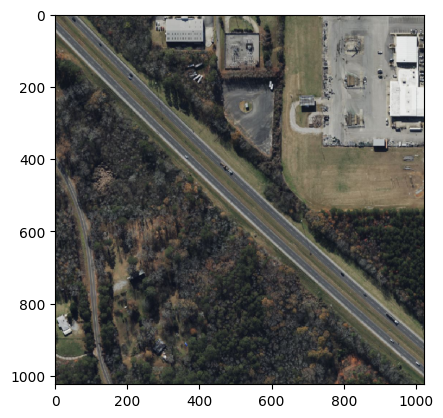

In [9]:
x = cv2.imread("/mnt/ssd1/nyh/AI_Competition/train_img/TRAIN_0000.png")
x_rgb = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
plt.imshow(x_rgb)

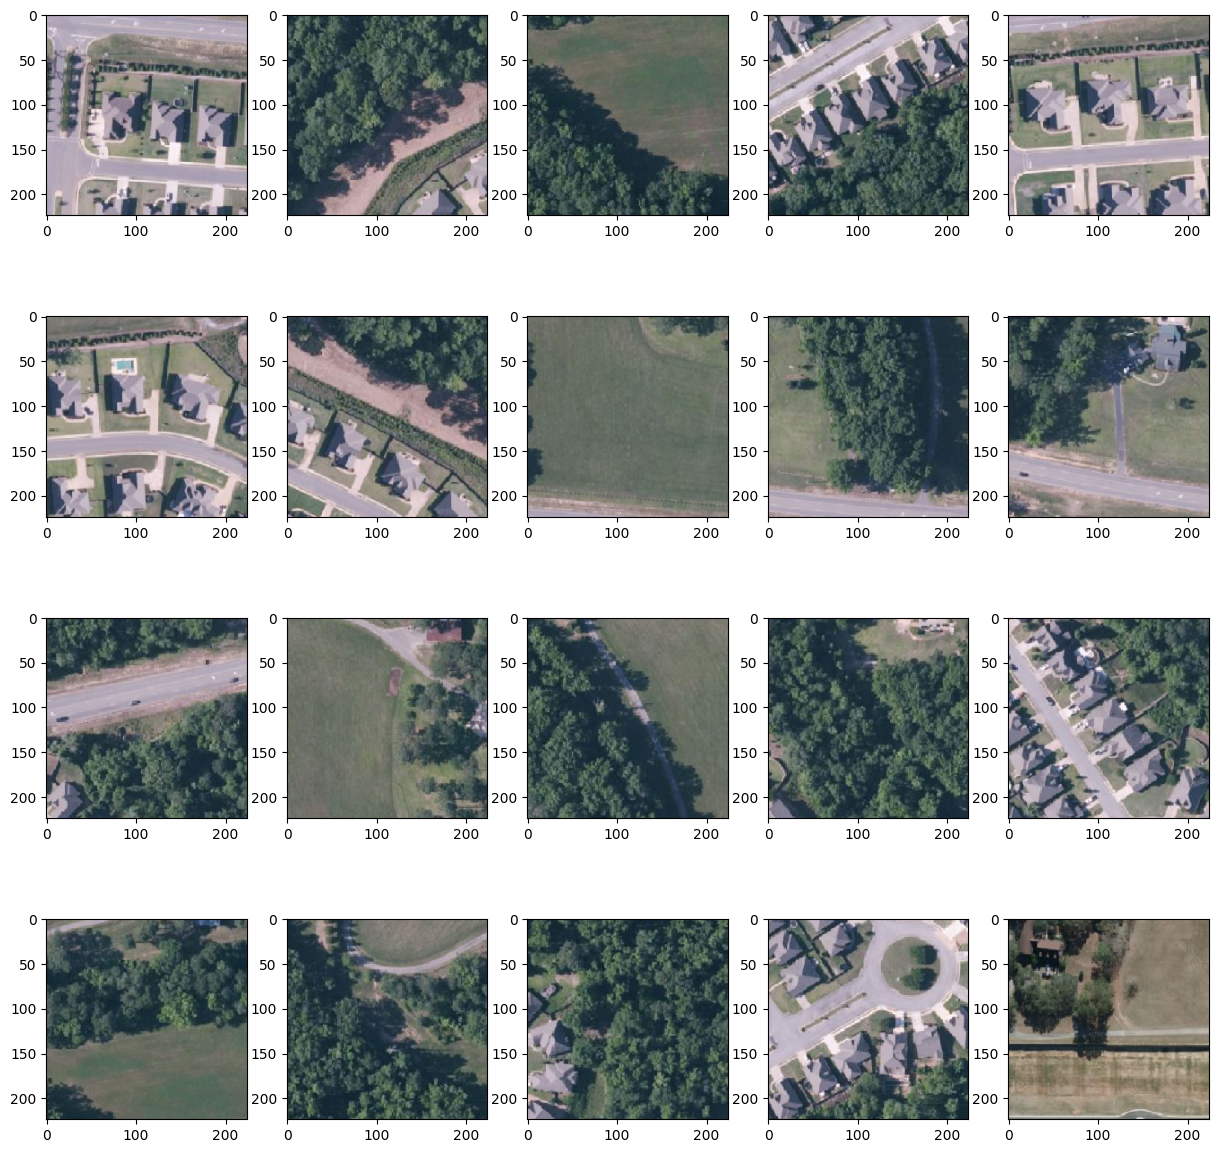

In [10]:
image = x_rgb
height, width, _ = image.shape
row_size = height // 4
col_size = width // 4

cnt = 0


fig, axes = plt.subplots(4, 5, figsize=(15, 15))

for r in range(4):
    for c in range(5):
        # sub_image = image[r * row_size: (r + 1) * row_size, c * col_size: (c + 1) * col_size]
        x = cv2.imread(f"/mnt/ssd1/nyh/AI_Competition/test_img/TEST_{str(cnt).zfill(5)}.png")
        x_rgb = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        sub_image = x_rgb
        axes[r, c].imshow(sub_image)
        # axes[r, c].axis('off')
        
        cnt+=1

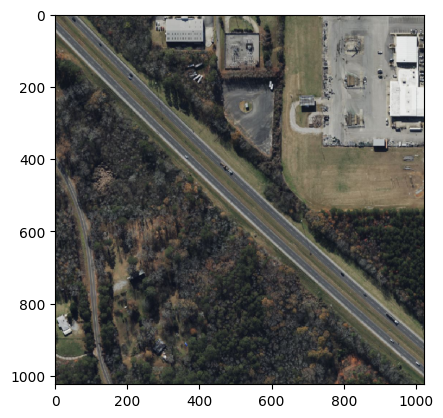

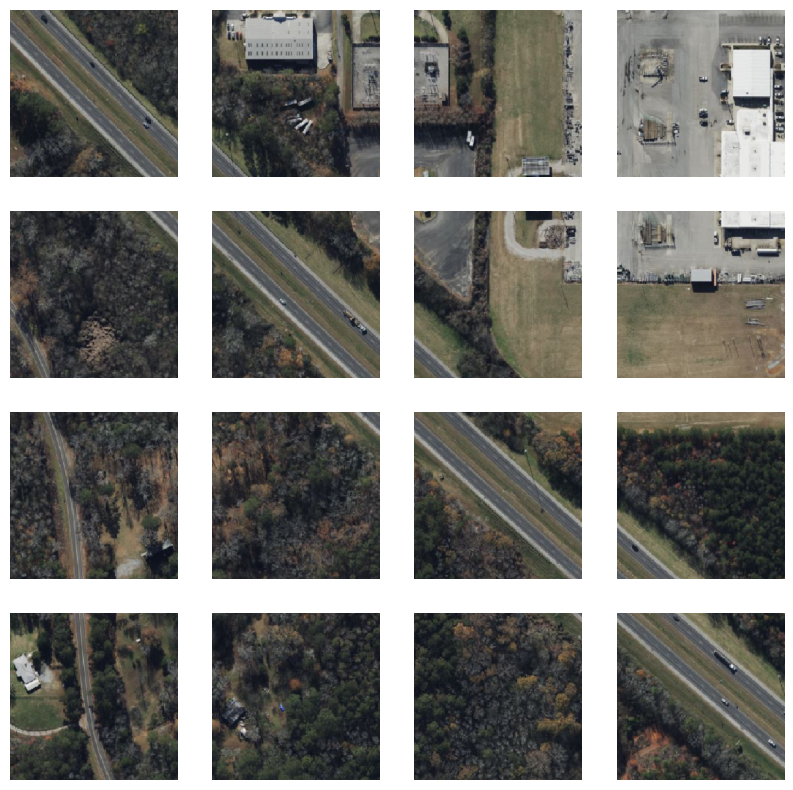

In [11]:
x = cv2.imread("/mnt/ssd1/nyh/AI_Competition/train_img/TRAIN_0000.png")
x_rgb = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
plt.imshow(x_rgb)

image = x_rgb
height, width, _ = image.shape

row_num = 6
col_num = 6
row_size = height // row_num
col_size = width // col_num
padding_size = 27

cnt = 1

fig, axes = plt.subplots(row_num, col_num, figsize=(10, 10))

for r in range(row_num):
    for c in range(col_num):
        sub_image = image[r * row_size - (r * padding_size): (r + 1) * row_size - (r * padding_size), c * col_size - (c * padding_size): (c + 1) * col_size - (c * padding_size)]
        axes[r, c].imshow(sub_image)
        axes[r, c].axis('off')
        
        cnt+=1